In [1]:
import gymnasium as gym
import stable_baselines3
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy
import mediapy as media

pygame 2.2.0 (SDL 2.30.2, Python 3.10.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline


def show_state(env, step=0, info=""):
    plt.figure(3)
    plt.clf()

    if isinstance(env, gym.wrappers.time_limit.TimeLimit):
      plt.imshow(env.render())
    elif isinstance(env, stable_baselines3.common.vec_env.dummy_vec_env.DummyVecEnv):
      plt.imshow(env.render("rgb_array"))
      
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(plt.gcf())


# RL for cart-pole
## Gym environment

In [3]:
env_id = "CartPole-v1"
env = gym.make(env_id, render_mode="rgb_array")

In [4]:
model = PPO('MlpPolicy', env_id, verbose=1)
model.learn(total_timesteps=3e4)
model.save("ppo_expert")


Using cpu device
Creating environment from the given name 'CartPole-v1'
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22.8     |
|    ep_rew_mean     | 22.8     |
| time/              |          |
|    fps             | 6528     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.8        |
|    ep_rew_mean          | 27.8        |
| time/                   |             |
|    fps                  | 3923        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007615175 |
|    clip_fraction        | 0.085       |
|    cl

KeyboardInterrupt: 

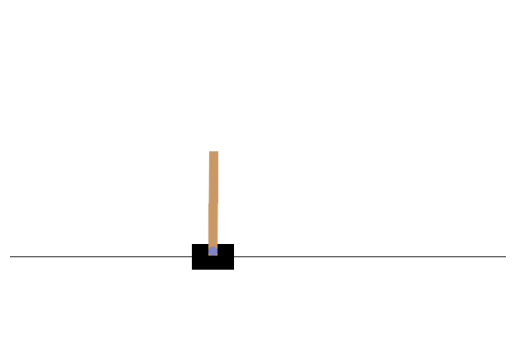

In [29]:
state, info = env.reset()
while True:
    action, _states = model.predict(state)
    state, rewards, dones, info, _ = env.step(action)
    show_state(env)

In [5]:
mean_reward, std_reward = evaluate_policy(model, env, n_eval_episodes=10)
print(f"Mean reward = {mean_reward} +/- {std_reward}")

/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Mean reward = 500.0 +/- 0.0


## SB3 Environment

In [33]:
import gymnasium as gym

from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env


KeyboardInterrupt: 

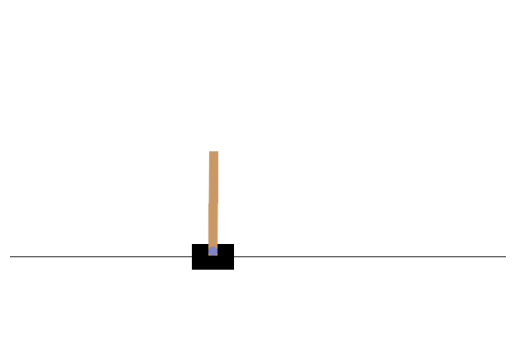

In [37]:
# SB3 vec env
vec_env = make_vec_env("CartPole-v1", n_envs=4)

model = PPO("MlpPolicy", vec_env, verbose=1)
model.learn(total_timesteps=25000)
model.save("ppo_cartpole")


In [ ]:

model = PPO.load("ppo_cartpole")

obs = vec_env.reset()
while True:
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    show_state(env)
    # vec_env.render("human")

# IL

In [3]:
import numpy as np
from imitation.policies.serialize import load_policy
from imitation.util.util import make_vec_env
from imitation.data import rollout
from imitation.algorithms import bc
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.util import logger


/Users/Eugene/miniconda3/envs/lerobot/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [4]:
def evaluation_video(policy, env):
  frames = []
  obs = env.reset()
  while len(frames) < 300:
      action, _states = policy.predict(obs)
      obs, rewards, dones, info = env.step(action)
      frames.append(env.render())

  media.show_video(frames, height=480)

In [5]:
env = make_vec_env(
    "seals:seals/CartPole-v0",
    rng=np.random.default_rng(), # random number generator
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
    env_make_kwargs={"render_mode":"rgb_array"}
)

In [14]:
expert = PPO("MlpPolicy", env, verbose=1)
expert.learn(total_timesteps=150000)
expert.save("ppo_cartpole")
reward, _ = evaluate_policy(expert, env, 10)
print(reward)
evaluation_video(expert, env)

Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 37.6     |
| time/              |          |
|    fps             | 24413    |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 16384    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | 40.8        |
| time/                   |             |
|    fps                  | 6515        |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 32768       |
| train/                  |             |
|    approx_kl            | 0.009124154 |
|    clip_fraction        | 0.0659      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.684      |
|    explained_variance   | 0.0505      |
|    learning

In [107]:

rng = np.random.default_rng()
rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=50),
    rng=rng,
)
transitions = rollout.flatten_trajectories(rollouts)


In [108]:
print(
    f"""The `rollout` function generated a list of {len(rollouts)} {type(rollouts[0])} of {len(rollouts[0])} steps each.
After flattening, this list is turned into a {type(transitions)} object containing {len(transitions)} transitions.
The transitions object contains arrays for: {', '.join(transitions.__dict__.keys())}."
"""
)

The `rollout` function generated a list of 56 <class 'imitation.data.types.TrajectoryWithRew'> of 500 steps each.
After flattening, this list is turned into a <class 'imitation.data.types.Transitions'> object containing 28000 transitions.
The transitions object contains arrays for: obs, acts, infos, next_obs, dones."



In [109]:
# mylogger = logger.configure('../runs/bc', format_strs=["tensorboard"])
bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    demonstrations=transitions,
    rng=rng,
    # custom_logger=mylogger
)

In [100]:
evaluation_video(bc_trainer.policy, env)

In [101]:
reward_before_training, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward before training: {reward_before_training}")

Reward before training: 237.1


In [110]:
bc_trainer.train(n_epochs=1)
reward_after_training, _ = evaluate_policy(bc_trainer.policy, env, 10)
print(f"Reward after training: {reward_after_training}")

0batch [00:00, ?batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 0         |
|    ent_loss       | -0.000693 |
|    entropy        | 0.693     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 72.5      |
|    loss           | 0.693     |
|    neglogp        | 0.693     |
|    prob_true_act  | 0.5       |
|    samples_so_far | 32        |
---------------------------------


494batch [00:00, 857.77batch/s]

---------------------------------
| batch_size        | 32        |
| bc/               |           |
|    batch          | 500       |
|    ent_loss       | -0.000509 |
|    entropy        | 0.509     |
|    epoch          | 0         |
|    l2_loss        | 0         |
|    l2_norm        | 84.8      |
|    loss           | 0.479     |
|    neglogp        | 0.48      |
|    prob_true_act  | 0.669     |
|    samples_so_far | 16032     |
---------------------------------


875batch [00:01, 794.11batch/s]


Reward after training: 500.0


In [111]:
evaluation_video(bc_trainer.policy, env)

## DAgger

In [103]:
import tempfile

from imitation.algorithms.dagger import SimpleDAggerTrainer

bc_trainer = bc.BC(
    observation_space=env.observation_space,
    action_space=env.action_space,
    rng=np.random.default_rng(),
)
expert = PPO("MlpPolicy", env, verbose=1)
expert.learn(total_timesteps=30000)
expert.save("ppo_cartpole_norollouts")


Using cpu device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 500      |
|    ep_rew_mean     | 31.8     |
| time/              |          |
|    fps             | 6347     |
|    iterations      | 1        |
|    time_elapsed    | 0        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 500         |
|    ep_rew_mean          | 26.8        |
| time/                   |             |
|    fps                  | 3620        |
|    iterations           | 2           |
|    time_elapsed         | 1           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.007319469 |
|    clip_fraction        | 0.0152      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.689      |
|    explained_variance   | -0.0114     |
|    learning

In [ ]:
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    print(tmpdir)
    dagger_trainer = SimpleDAggerTrainer(
        venv=env,
        scratch_dir=tmpdir,
        expert_policy=expert,
        bc_trainer=bc_trainer,
        rng=np.random.default_rng(),
    )

    dagger_trainer.train(2000)

In [109]:
with tempfile.TemporaryDirectory(prefix="dagger_example_") as tmpdir:
    print("::" in tmpdir)

False


## GAIL
Generative adversarial imitation learning trains a reward network on an expert. The reward network is then used to train the policy

In [30]:
from imitation.algorithms.adversarial.gail import GAIL
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from stable_baselines3 import PPO
from stable_baselines3.common.evaluation import evaluate_policy


In [31]:
SEED = 42

env = make_vec_env(
    "seals:seals/CartPole-v0",
    rng=np.random.default_rng(SEED),
    # n_envs=8,
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
    env_make_kwargs={"render_mode":"rgb_array"}
)

expert = PPO.load("ppo_cartpole")

rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=60),
    rng=np.random.default_rng(),
)

In [32]:
mylogger = logger.configure('../runs/GAIL/', format_strs=["tensorboard"])

learner = PPO(
    env=env,
    policy='MlpPolicy',
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0004,
    gamma=0.95,
    n_epochs=5,
    seed=SEED,
)
reward_net = BasicRewardNet(
    observation_space=env.observation_space,
    action_space=env.action_space,
    normalize_input_layer=RunningNorm,
)


gail_trainer = GAIL(
    demonstrations=rollouts,
    demo_batch_size=1024,
    gen_replay_buffer_capacity=512,
    n_disc_updates_per_round=8,
    venv=env,
    gen_algo=learner,
    reward_net=reward_net,
    custom_logger=mylogger
    # log_dir='../runs',
    # init_tensorboard=True,
    # init_tensorboard_graph=True
)

In [33]:
env.seed(SEED)
learner_rewards_before_training, _ = evaluate_policy(
    learner, env, 100, return_episode_rewards=True
)
print(
    "Rewards before training:",
    np.mean(learner_rewards_before_training),
    "+/-",
    np.std(learner_rewards_before_training),
)

Rewards before training: 102.6 +/- 24.11514047232568


In [34]:
gail_trainer.train(800_000)

round: 100%|██████████████████████████████████████| 48/48 [02:27<00:00,  3.08s/it]


In [35]:
env.seed(SEED)
learner_rewards_after_training, _ = evaluate_policy(
    learner, env, 100, return_episode_rewards=True
)
print(
    "Rewards after training:",
    np.mean(learner_rewards_after_training),
    "+/-",
    np.std(learner_rewards_after_training),
)
evaluation_video(learner, env)


Rewards after training: 500.0 +/- 0.0


Tensorboard output after 300,000 steps
ep_rew_mean seems to be the most useful, just wait for it to get to 500. The other signals seem noiser and less consistent


![Screenshot 2024-06-29 at 14.51.35.png](<attachment:Screenshot 2024-06-29 at 14.51.35.png>)
![Screenshot 2024-06-29 at 14.51.44.png](<attachment:Screenshot 2024-06-29 at 14.51.44.png>)
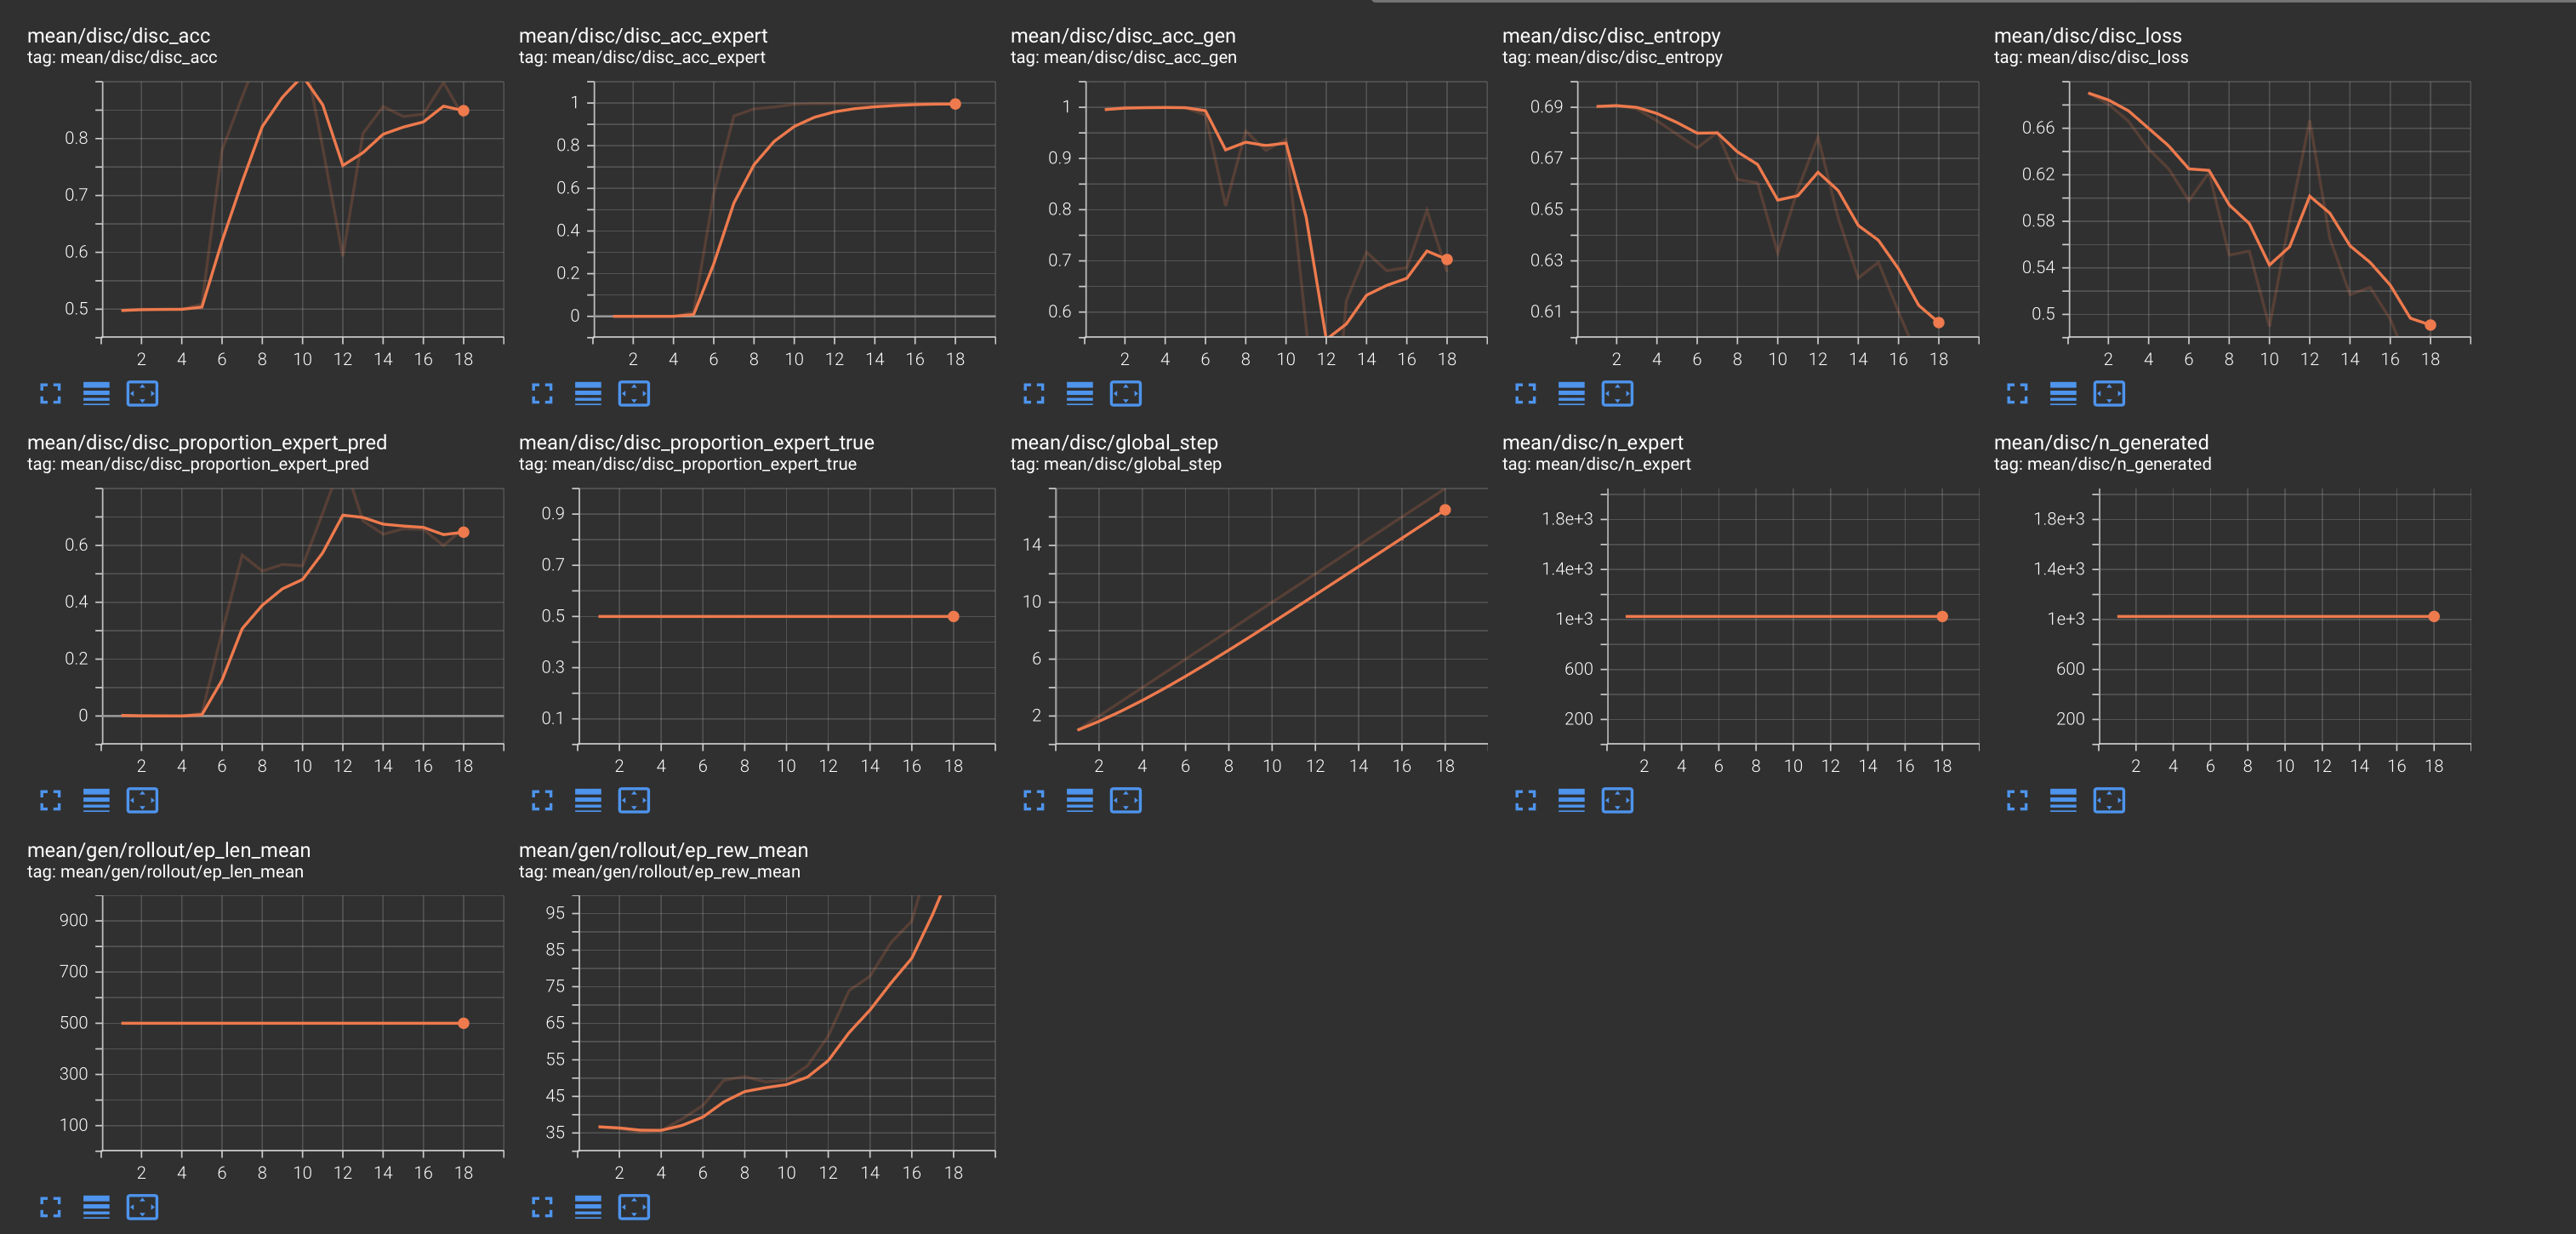
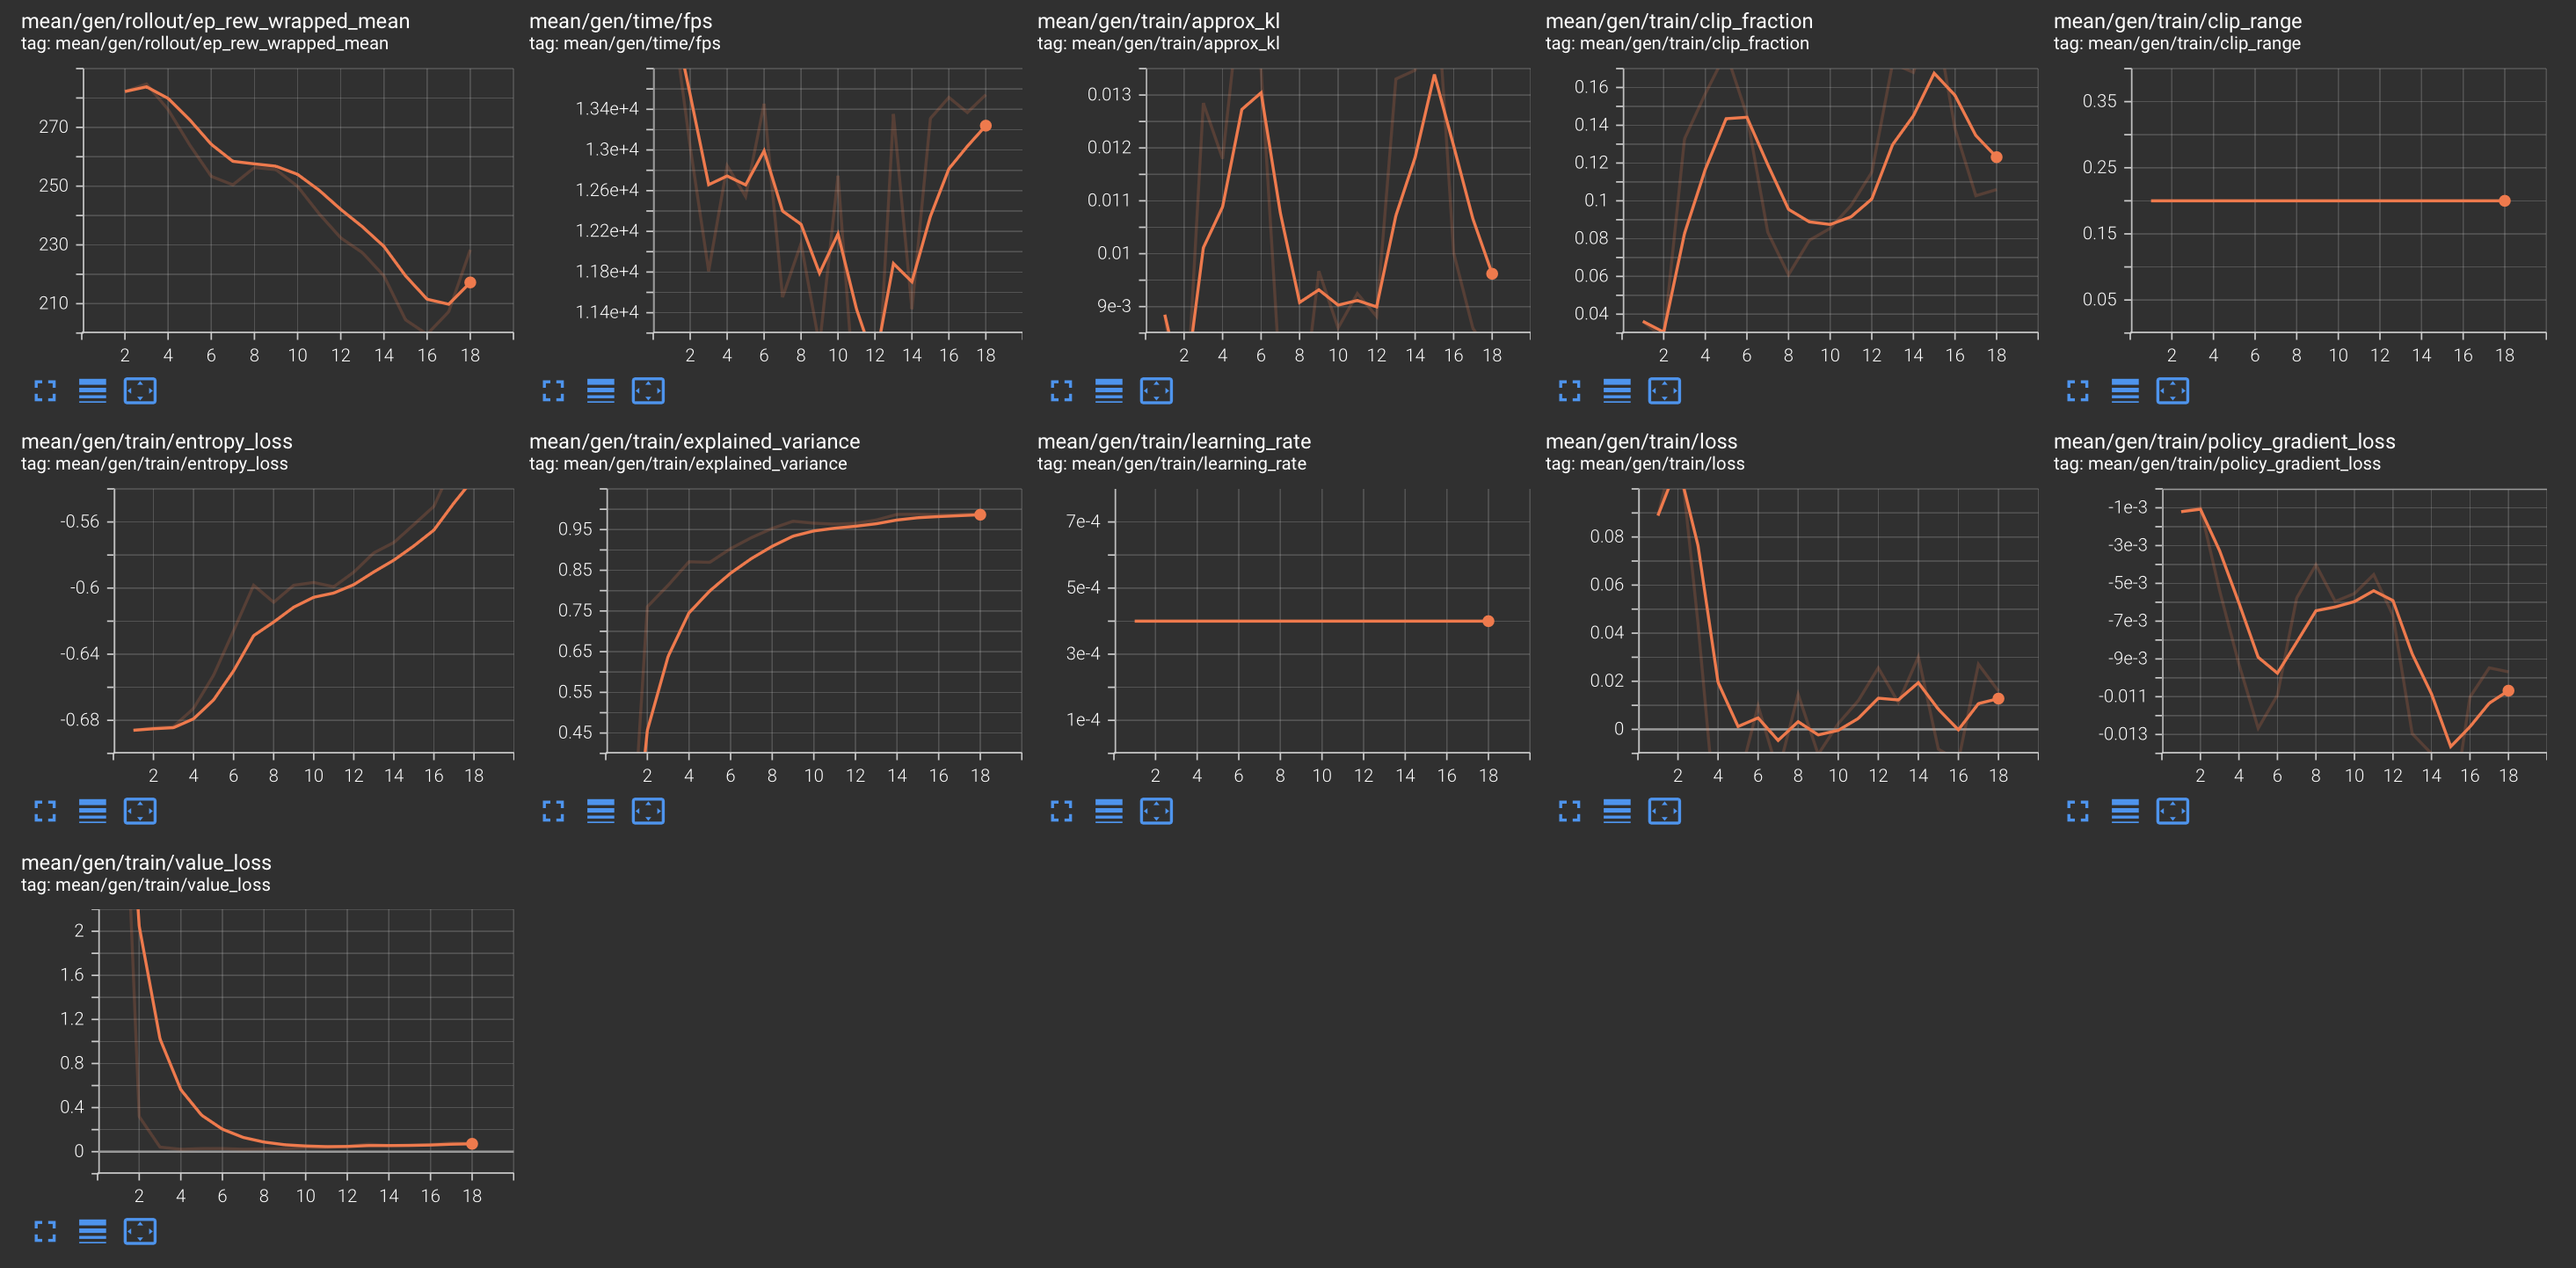

## AIRL



In [23]:
from imitation.algorithms.adversarial.airl import AIRL
from imitation.rewards.reward_nets import BasicShapedRewardNet
from imitation.util.networks import RunningNorm

FAST = False

if FAST:
    N_RL_TRAIN_STEPS = 100_000
else:
    N_RL_TRAIN_STEPS = 800_000

SEED = 42

env = make_vec_env(
    "seals:seals/CartPole-v0",
    rng=np.random.default_rng(SEED),
    # n_envs=8,
    post_wrappers=[
        lambda env, _: RolloutInfoWrapper(env)
    ],  # needed for computing rollouts later
    env_make_kwargs={"render_mode":"rgb_array"}
)

expert = PPO.load("ppo_cartpole")

rollouts = rollout.rollout(
    expert,
    env,
    rollout.make_sample_until(min_timesteps=None, min_episodes=60),
    rng=np.random.default_rng(),
)

learner = PPO(
    env=env,
    policy='MlpPolicy',
    batch_size=64,
    ent_coef=0.0,
    learning_rate=0.0005,
    gamma=0.95,
    clip_range=0.1,
    vf_coef=0.1,
    n_epochs=5,
    seed=SEED,
)
reward_net = BasicShapedRewardNet(
    observation_space=env.observation_space,
    action_space=env.action_space,
    normalize_input_layer=RunningNorm,
)

mylogger = logger.configure('../runs/AIRL', format_strs=["tensorboard"])

airl_trainer = AIRL(
    demonstrations=rollouts,
    demo_batch_size=2048,
    gen_replay_buffer_capacity=512,
    n_disc_updates_per_round=16,
    venv=env,
    gen_algo=learner,
    reward_net=reward_net,
    custom_logger=mylogger
)


In [24]:
# Check expert
reward, _ = evaluate_policy(expert, env, 10)
print(reward)


500.0


In [26]:

env.seed(SEED)
learner_rewards_before_training, _ = evaluate_policy(
    learner, env, 100, return_episode_rewards=True
)
airl_trainer.train(N_RL_TRAIN_STEPS)
env.seed(SEED)
learner_rewards_after_training, _ = evaluate_policy(
    learner, env, 100, return_episode_rewards=True
)

In [27]:
print(
    "Rewards before training:",
    np.mean(learner_rewards_before_training),
    "+/-",
    np.std(learner_rewards_before_training),
)
print(
    "Rewards after training:",
    np.mean(learner_rewards_after_training),
    "+/-",
    np.std(learner_rewards_after_training),
)

Rewards before training: 102.6 +/- 24.11514047232568
Rewards after training: 500.0 +/- 0.0


In [28]:
evaluation_video(learner, env)

## Preference Comparison

In [36]:
import random
from imitation.algorithms import preference_comparisons
from imitation.rewards.reward_nets import BasicRewardNet
from imitation.util.networks import RunningNorm
from imitation.util.util import make_vec_env
from imitation.policies.base import FeedForward32Policy, NormalizeFeaturesExtractor
import gymnasium as gym
from stable_baselines3 import PPO
import numpy as np

In [38]:
rng = np.random.default_rng(0)
reward_net = BasicRewardNet(
    env.observation_space, env.action_space, normalize_input_layer=RunningNorm
)

fragmenter = preference_comparisons.RandomFragmenter(
    warning_threshold=0,
    rng=rng,
)
gatherer = preference_comparisons.SyntheticGatherer(rng=rng)
preference_model = preference_comparisons.PreferenceModel(reward_net)
reward_trainer = preference_comparisons.BasicRewardTrainer(
    preference_model=preference_model,
    loss=preference_comparisons.CrossEntropyRewardLoss(),
    epochs=3,
    rng=rng,
)

In [ ]:
agent = PPO(
    policy=FeedForward32Policy,
    policy_kwargs=dict(
        features_extractor_class=NormalizeFeaturesExtractor,
        features_extractor_kwargs=dict(normalize_class=RunningNorm),
    ),
    env=env,
    seed=0,
    n_steps=2048 // env.num_envs,
    batch_size=64,
    ent_coef=0.01,
    learning_rate=2e-3,
    clip_range=0.1,
    gae_lambda=0.95,
    gamma=0.97,
    n_epochs=10,
)


trajectory_generator = preference_comparisons.AgentTrainer(
    algorithm=agent,
    reward_fn=reward_net,
    venv=env,
    exploration_frac=0.05,
    rng=rng,
)

pref_comparisons = preference_comparisons.PreferenceComparisons(
    trajectory_generator,
    reward_net,
    num_iterations=5,  # Set to 60 for better performance
    fragmenter=fragmenter,
    preference_gatherer=gatherer,
    reward_trainer=reward_trainer,
    fragment_length=100,
    transition_oversampling=1,
    initial_comparison_frac=0.1,
    allow_variable_horizon=False,
    initial_epoch_multiplier=4,
    query_schedule="hyperbolic",
)